<a href="https://colab.research.google.com/github/KNL1979/DS807/blob/main/Q3_1_CNN_model_resized_images_(Transferlearning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, Reshape, BatchNormalization, MaxPooling2D, SpatialDropout2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import PIL

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Mount Drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Set Directory

In [5]:
%cd '/content/gdrive/My Drive/AML_Exam/problem1/'

/content/gdrive/My Drive/AML_Exam/problem1


# Load data

In [6]:
# Load features
X_train_original = np.load('AE/datasets/X_train_new.npy')
X_val_original = np.load('AE/datasets/X_val_new.npy')
X_test_original = np.load('AE/datasets/X_test_new.npy')

# Load labels
y_train = np.load('y_train_new.npy')
y_val = np.load('y_val_new.npy')
y_test = np.load('y_test_new.npy')

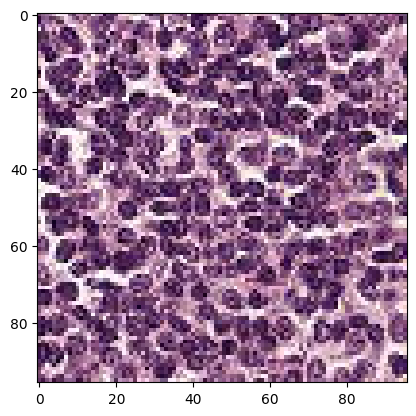

In [7]:
plt.imshow(X_train_original[0])

In [8]:
print("Original Image Shapes:")
print(X_train_original.shape, X_val_original.shape, X_test_original.shape)
print("Label Shapes:")
print(y_train.shape, y_val.shape, y_test.shape)

Original Image Shapes:
(55050, 96, 96, 3) (15729, 96, 96, 3) (7864, 96, 96, 3)
Label Shapes:
(55050, 2) (15729, 2) (7864, 2)


# Resize data

In [9]:
def resize_image(image):
    image = tf.image.resize(image, [32, 32,])
    return image

# Apply resize_image function to each set of images
X_train_resized = np.array([resize_image(img) for img in X_train_original])
X_val_resized = np.array([resize_image(img) for img in X_val_original])
X_test_resized = np.array([resize_image(img) for img in X_test_original])

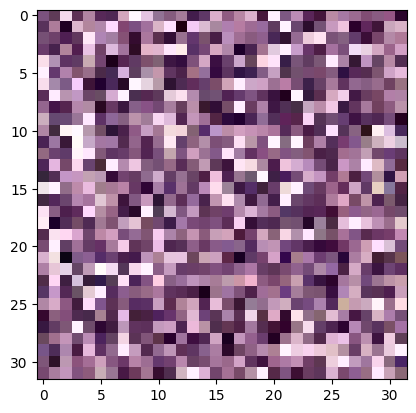

In [10]:
# Plot the first resized image with a grayscale colormap
plt.imshow(X_train_resized[0])

In [17]:
print("Resized Image Shapes:")
print(X_train_resized.shape, X_val_resized.shape, X_test_resized.shape)
print("Label Shapes:")
print(y_train.shape, y_val.shape, y_test.shape)

Resized Image Shapes:
(55050, 32, 32, 1) (15729, 32, 32, 1) (7864, 32, 32, 1)
Label Shapes:
(55050, 2) (15729, 2) (7864, 2)


# Adding data augmentation
Increase existing dataset with additional 20% augmented images

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

def generate_augmented_data(X_train_resized, y_train, augmentation_ratio, batch_size=32):
    # Create an ImageDataGenerator
    datagen = ImageDataGenerator(
        rotation_range=40,
        horizontal_flip=True,
        vertical_flip=False,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        shear_range=0.2
    )

    # Calculate the number of augmented images to generate
    original_images_count = len(X_train_resized)
    augmented_images_count = int(original_images_count * augmentation_ratio)

    # Generate augmented data
    augmented_data = datagen.flow(X_train_resized, y_train, batch_size=batch_size, shuffle=False)

    # Iterate to accumulate augmented images
    X_augmented = []
    y_augmented = []
    for _ in range(augmented_images_count // batch_size):
        augmented_images, augmented_labels = augmented_data.next()
        X_augmented.append(augmented_images)
        y_augmented.append(augmented_labels)

    # Concatenate original and augmented data
    X_augmented = np.concatenate([X_train_resized, np.concatenate(X_augmented)])
    y_augmented = np.concatenate([y_train, np.concatenate(y_augmented)])

    return X_augmented, y_augmented

# Example usage
augmentation_ratio = 0.2
X_augmented, y_augmented = generate_augmented_data(X_train_resized, y_train, augmentation_ratio)
print(X_augmented.shape, y_augmented.shape)


(66058, 32, 32, 3) (66058, 2)


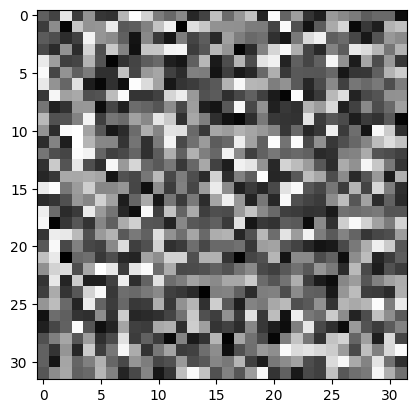

In [20]:
# Plot the first resized image with a grayscale colormap
plt.imshow(X_augmented[0][:, :, 0], cmap='gray')
plt.show()

# **Transferlearning with images resized and augmented**



# Create TensorFlow dataset for original images

In [ ]:
# Create TensorFlow datasets for training, validation, and test sets
train_dataset1 = tf.data.Dataset.from_tensor_slices((X_train_original, y_train))
val_dataset1 = tf.data.Dataset.from_tensor_slices((X_val_original, y_val))
test_dataset1 = tf.data.Dataset.from_tensor_slices((X_test_original, y_test))

# Define constants
BATCH_SIZE = 26

# Function to resize and preprocess the images
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image
    image = tf.image.resize_with_pad(image, 224, 224, method='lanczos3', antialias=True)
    return image, label

# Apply the format_image function and prepare the datasets
train_dataset1 = train_dataset1.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
val_dataset1 = val_dataset1.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset1 = test_dataset1.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Display information about the datasets
print("Training Dataset Info:")
print(f'Number of samples: {len(X_train_original)}')
print(f'Batch size: {BATCH_SIZE}\n')

print("Validation Dataset Info:")
print(f'Number of samples: {len(X_val_original)}')
print(f'Batch size: {BATCH_SIZE}\n')

print("Test Dataset Info:")
print(f'Number of samples: {len(X_test_original)}')
print(f'Batch size: {BATCH_SIZE}\n')

# Check the processed images
for batch in train_dataset1.take(1):
    images, labels = batch
    print("Processed Training Batch Shapes:")
    print(images.shape, labels.shape)

for batch in val_dataset1.take(1):
    images, labels = batch
    print("Processed Val Batch Shapes:")
    print(images.shape, labels.shape)


Training Dataset Info:
Number of samples: 55050
Batch size: 26

Validation Dataset Info:
Number of samples: 15729
Batch size: 26

Test Dataset Info:
Number of samples: 7864
Batch size: 26

Processed Training Batch Shapes:
(26, 224, 224, 3) (26, 2)
Processed Val Batch Shapes:
(26, 224, 224, 3) (26, 2)


# Create TensorFlow dataset for resized images

In [11]:
# Create TensorFlow datasets for training, validation, and test sets
train_dataset2 = tf.data.Dataset.from_tensor_slices((X_train_resized, y_train))
val_dataset2 = tf.data.Dataset.from_tensor_slices((X_val_resized, y_val))
test_dataset2 = tf.data.Dataset.from_tensor_slices((X_test_resized, y_test))

# Define constants
BATCH_SIZE = 26

# Function to resize and preprocess the images
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image
    image = tf.image.resize_with_pad(image, 224, 224, method='lanczos3', antialias=True)
    return image, label

# Apply the format_image function and prepare the datasets
train_dataset2 = train_dataset2.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
val_dataset2 = val_dataset2.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset2 = test_dataset2.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Display information about the datasets
print("Training Dataset Info:")
print(f'Number of samples: {len(X_train_resized)}')
print(f'Batch size: {BATCH_SIZE}\n')

print("Validation Dataset Info:")
print(f'Number of samples: {len(X_val_resized)}')
print(f'Batch size: {BATCH_SIZE}\n')

print("Test Dataset Info:")
print(f'Number of samples: {len(X_test_resized)}')
print(f'Batch size: {BATCH_SIZE}\n')

# Check the processed images
for batch in train_dataset2.take(1):
    images, labels = batch
    print("Processed Training Batch Shapes:")
    print(images.shape, labels.shape)

for batch in val_dataset2.take(1):
    images, labels = batch
    print("Processed Val Batch Shapes:")
    print(images.shape, labels.shape)


Training Dataset Info:
Number of samples: 55050
Batch size: 26

Validation Dataset Info:
Number of samples: 15729
Batch size: 26

Test Dataset Info:
Number of samples: 7864
Batch size: 26

Processed Training Batch Shapes:
(26, 224, 224, 3) (26, 2)
Processed Val Batch Shapes:
(26, 224, 224, 3) (26, 2)


# Create TensorFlow dataset for resized and augmented images

In [22]:
# Create TensorFlow datasets for training, validation, and test sets
train_dataset3 = tf.data.Dataset.from_tensor_slices((X_augmented, y_augmented))
val_dataset3 = tf.data.Dataset.from_tensor_slices((X_val_original, y_val))
test_dataset3 = tf.data.Dataset.from_tensor_slices((X_test_original, y_test))

# Define constants
BATCH_SIZE = 26

# Function to resize and preprocess the images
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image
    image = tf.image.resize_with_pad(image, 224, 224, method='lanczos3', antialias=True)
    return image, label

# Apply the format_image function and prepare the datasets
train_dataset = train_dataset3.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
val_dataset = val_dataset3.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset3.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Display information about the datasets
print("Training Dataset Info:")
print(f'Number of samples: {len(X_augmented)}')
print(f'Batch size: {BATCH_SIZE}\n')

print("Validation Dataset Info:")
print(f'Number of samples: {len(X_val_original)}')
print(f'Batch size: {BATCH_SIZE}\n')

print("Test Dataset Info:")
print(f'Number of samples: {len(X_test_original)}')
print(f'Batch size: {BATCH_SIZE}\n')

# Check the processed images
for batch in train_dataset3.take(1):
    images, labels = batch
    print("Processed Training Batch Shapes:")
    print(images.shape, labels.shape)

for batch in val_dataset3.take(1):
    images, labels = batch
    print("Processed Val Batch Shapes:")
    print(images.shape, labels.shape)


Training Dataset Info:
Number of samples: 66058
Batch size: 26

Validation Dataset Info:
Number of samples: 15729
Batch size: 26

Test Dataset Info:
Number of samples: 7864
Batch size: 26

Processed Training Batch Shapes:
(32, 32, 1) (2,)
Processed Val Batch Shapes:
(96, 96, 3) (2,)


# Transferlearning - Combining pretrained Renet50 model with our own prediction head

In [12]:
# Create ResNet50 base model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the ResNet50 base model
for layer in resnet_base.layers:
    layer.trainable = False

# Build the custom prediction head
model_head = Flatten()(resnet_base.output)
model_head = Dense(1024, activation='relu')(model_head)
model_head = BatchNormalization()(model_head)
model_head = Dropout(0.5)(model_head)

model_head = Dense(1024, activation='relu')(model_head)
model_head = BatchNormalization()(model_head)
model_head = Dropout(0.5)(model_head)

# Output layer
output_layer = Dense(2, activation='softmax')(model_head)

# Create the final model by combining ResNet50 base and custom prediction head
model = Model(inputs=resnet_base.input, outputs=output_layer)

# Define optimizer
lr = 0.00000575676901354386
adam_optimizer = Adam(learning_rate=lr)

# Compile the model with an appropriate optimizer, loss, and metrics
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, mode='max', restore_best_weights=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

# Train models

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Train the model
history1 = model.fit(
    train_dataset1,
    validation_data=val_dataset1,
    callbacks=early_stopping,
    epochs = 50
)

Epoch 1/50
2118/2118 [==============================] - 104s 45ms/step - loss: 0.8300 - accuracy: 0.6812 - val_loss: 0.5874 - val_accuracy: 0.7437
Epoch 2/50
2118/2118 [==============================] - 59s 28ms/step - loss: 0.7504 - accuracy: 0.7016 - val_loss: 0.4995 - val_accuracy: 0.7719
Epoch 3/50
2118/2118 [==============================] - 58s 28ms/step - loss: 0.7179 - accuracy: 0.7074 - val_loss: 0.4877 - val_accuracy: 0.7775
Epoch 4/50
2118/2118 [==============================] - 58s 27ms/step - loss: 0.6919 - accuracy: 0.7150 - val_loss: 0.5016 - val_accuracy: 0.7778
Epoch 5/50
2118/2118 [==============================] - 58s 27ms/step - loss: 0.6704 - accuracy: 0.7206 - val_loss: 0.4972 - val_accuracy: 0.7778
Epoch 6/50
2118/2118 [==============================] - 58s 27ms/step - loss: 0.6584 - accuracy: 0.7238 - val_loss: 0.5230 - val_accuracy: 0.7660
Epoch 7/50
2118/2118 [==============================] - 58s 28ms/step - loss: 0.6423 - accuracy: 0.7278 - val_loss: 0.4739 

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

# Train the model
history2 = model.fit(
    train_dataset2,
    validation_data=val_dataset2,
    callbacks=early_stopping,
    epochs = 50
)

Epoch 1/50
2118/2118 [==============================] - 122s 53ms/step - loss: 0.8880 - accuracy: 0.6636 - val_loss: 0.6519 - val_accuracy: 0.7059
Epoch 2/50
2118/2118 [==============================] - 91s 43ms/step - loss: 0.8075 - accuracy: 0.6836 - val_loss: 0.5603 - val_accuracy: 0.7543
Epoch 3/50
2118/2118 [==============================] - 90s 43ms/step - loss: 0.7729 - accuracy: 0.6898 - val_loss: 0.5591 - val_accuracy: 0.7452
Epoch 4/50
2118/2118 [==============================] - 90s 43ms/step - loss: 0.7451 - accuracy: 0.6928 - val_loss: 0.5742 - val_accuracy: 0.7482
Epoch 5/50
2118/2118 [==============================] - 90s 42ms/step - loss: 0.7314 - accuracy: 0.6974 - val_loss: 0.5551 - val_accuracy: 0.7510
Epoch 6/50
2118/2118 [==============================] - 91s 43ms/step - loss: 0.7143 - accuracy: 0.7006 - val_loss: 0.5971 - val_accuracy: 0.7363


# On the test set

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset2)

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

303/303 [==============================] - 9s 31ms/step - loss: 0.5558 - accuracy: 0.7531
Test Accuracy: 75.31%


# Visualize training history

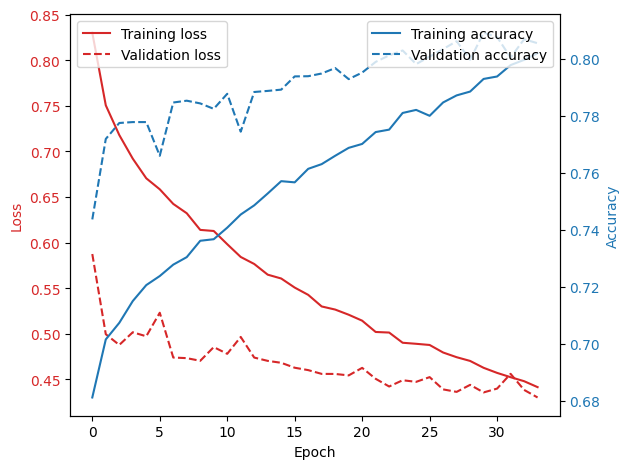

In [ ]:
# Visualize training history
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(history1.history['loss'], label='Training loss', color=color)
ax1.plot(history1.history['val_loss'], label='Validation loss', linestyle='dashed', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(history1.history['accuracy'], label='Training accuracy', color=color)
ax2.plot(history1.history['val_accuracy'], label='Validation accuracy', linestyle='dashed', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()

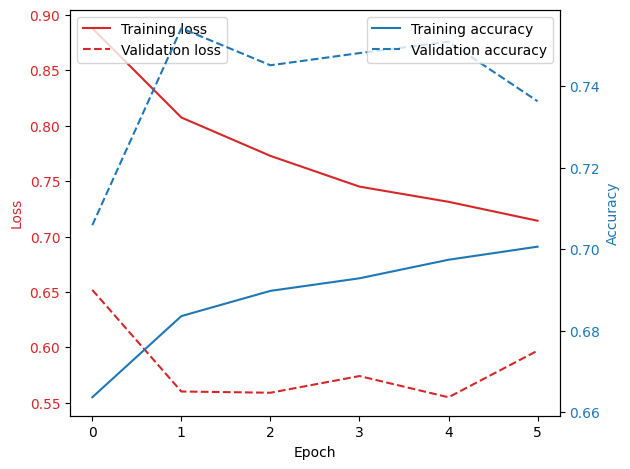

In [16]:
# Visualize training history
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(history2.history['loss'], label='Training loss', color=color)
ax1.plot(history2.history['val_loss'], label='Validation loss', linestyle='dashed', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(history2.history['accuracy'], label='Training accuracy', color=color)
ax2.plot(history2.history['val_accuracy'], label='Validation accuracy', linestyle='dashed', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()